In [41]:
import pandas as pd
import numpy as np

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [44]:
data=pd.read_csv('/content/drive/MyDrive/Dataset/data/Twitter Analysis.csv')
data.head()

,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,1,3,0,0,1,6,8,1,30
4,4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,...,0,1,3,0,1,0,11,3,2,19


In [45]:
# Separate data into '0' and '1' classes
data_0 = data[data['BotScoreBinary'] == 0]
data_1 = data[data['BotScoreBinary'] == 1]

In [46]:
# Count the initial distribution
print("Bot count:", len(data_1))
print("Human count:", len(data_0))

Bot count: 4342
Human count: 129856


In [47]:
# Randomly select 20,000 rows from '0' class if available
if len(data_0) > 20000:
    data_0 = data_0.sample(n=20000, random_state=42)

In [48]:
# Combine reduced '0' class with '1' class
data = pd.concat([data_0, data_1], ignore_index=True)

In [49]:
# Separate features and target
x = data.drop(columns=['BotScoreBinary'])
y = data['BotScoreBinary']

In [50]:
y.value_counts()

,count
BotScoreBinary,
0.0,20000
1.0,4342


In [51]:
# Text data (tweet) preprocessing
max_words = 1000  # Max number of words in tokenizer
max_sequence_length = 100  # Max length of each sequence (tweets)


In [52]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x['tweet'])
sequences = tokenizer.texts_to_sequences(x['tweet'])
x_text = pad_sequences(sequences, maxlen=max_sequence_length)

In [53]:
# Numeric features scaling
numeric_features = [
    'followers_count', 'friends_count', 'statuses_count', 'listed_count',
    'retweets', 'mentions', 'Word count', 'adjectives', 'adverbs',
    'pronouns', 'capitals', 'digits', 'hashtags', 'URLs', 'ORG_percentage',
    'PERSON_percentage', 'cred', 'normalize_influence'
]

In [54]:
x_numeric = data[numeric_features].values
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x_numeric)

In [55]:
# Split data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text, x_numeric_scaled, y, test_size=0.2, random_state=42)

In [56]:
# Address class imbalance
smote = SMOTE(random_state=42)
x_train_text_resampled, y_train_resampled = smote.fit_resample(x_train_text, y_train)
x_train_numeric_resampled, y_train_resampled = smote.fit_resample(x_train_numeric, y_train)

In [57]:
# Calculate the number of bots and humans after SMOTE
bots_after_smote = sum(y_train_resampled)
humans_after_smote = len(y_train_resampled) - bots_after_smote

In [58]:
print(f'Bots after SMOTE: {bots_after_smote}')
print(f'Humans after SMOTE: {humans_after_smote}')

Bots after SMOTE: 15974.0
Humans after SMOTE: 15974.0


In [59]:
# Define RNN model architecture
embedding_dim = 50  # Dimension of word embeddings

In [60]:
# Text input branch
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input)
lstm_layer = LSTM(30, kernel_regularizer=l2(0.01))(embedding_layer)
dropout_text = Dropout(0.5)(lstm_layer)

In [61]:
# Numeric input branch
numeric_input = Input(shape=(len(numeric_features),), name='numeric_input')
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numeric_input)
dropout_numeric = Dropout(0.5)(dense_layer)

In [62]:
# Concatenate both branches
concatenated = concatenate([dropout_text, dropout_numeric])

In [63]:
# Output layer
output = Dense(1, activation='sigmoid', name='output')(concatenated)

In [64]:
# Create model
model = Model(inputs={'text_input': text_input, 'numeric_input': numeric_input}, outputs=output)

In [65]:
# Define optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [66]:
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 50)        │         50,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 30)             │          9,720 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          1,216 │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 30)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 94)             │              0 │ dropout_2[0][0],       │
│ (Concatenate)             │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             95 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,031 (238.40 KB)

 Trainable params: 61,031 (238.40 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [68]:
print("x_train_text_resampled shape:", x_train_text_resampled.shape)
print("x_train_numeric_resampled shape:", x_train_numeric_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

x_train_text_resampled shape: (31948, 100)
x_train_numeric_resampled shape: (31948, 18)
y_train_resampled shape: (31948,)


In [69]:
# Train model
history = model.fit(
    {'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled},
    y_train_resampled,
    epochs=20,
    batch_size=64,
    validation_data=({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6211 - loss: 1.4995 - val_accuracy: 0.7848 - val_loss: 1.0616
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7590 - loss: 0.9863 - val_accuracy: 0.8004 - val_loss: 0.7793
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8037 - loss: 0.7199 - val_accuracy: 0.8431 - val_loss: 0.5850
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8414 - loss: 0.5625 - val_accuracy: 0.8647 - val_loss: 0.4850
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8612 - loss: 0.4741 - val_accuracy: 0.8649 - val_loss: 0.4523
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8784 - loss: 0.4148 - val_accuracy: 0.8794 - val_loss: 0.3955
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8902 - loss: 0.3788 - val_accuracy: 0.8979 - val_loss: 0.3477
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8941 - loss: 0.3494 - val_accurac

In [70]:
# Evaluate model on train set
train_loss, train_accuracy = model.evaluate({'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled}, y_train_resampled)
print(f'Train accuracy: {train_accuracy}')


999/999 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9155 - loss: 0.2559
Train accuracy: 0.9182421565055847


In [71]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test)
print(f'Test accuracy: {test_accuracy}')

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8985 - loss: 0.2912
Test accuracy: 0.9036763310432434


In [72]:
import matplotlib.pyplot as plt


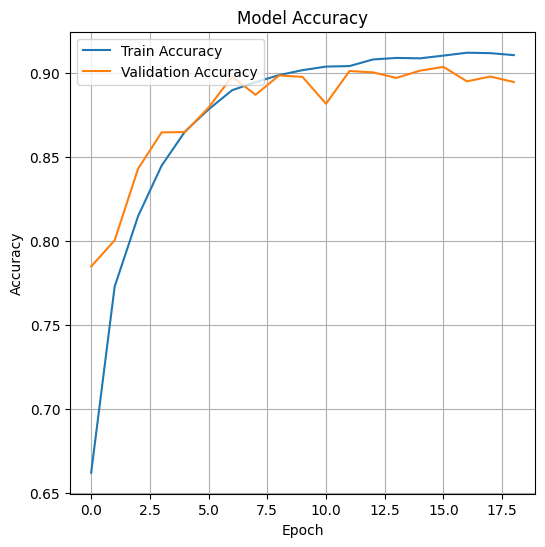

In [73]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [74]:
# Predict on test set
y_pred = model.predict({'text_input': x_test_text, 'numeric_input': x_test_numeric})
y_pred_classes = (y_pred > 0.5).astype(int)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [75]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[3707  319]
 [ 150  693]]


In [76]:
# Calculate sensitivity and specificity

from sklearn.metrics import recall_score

sensitivity_alt = recall_score(y_test, y_pred_classes)
specificity_alt = recall_score(y_test, y_pred_classes, pos_label=0)

print(f"Sensitivity (using sklearn): {sensitivity_alt:.4f}")
print(f"Specificity (using sklearn): {specificity_alt:.4f}")

Sensitivity (using sklearn): 0.8221
Specificity (using sklearn): 0.9208


In [77]:
import seaborn as sns

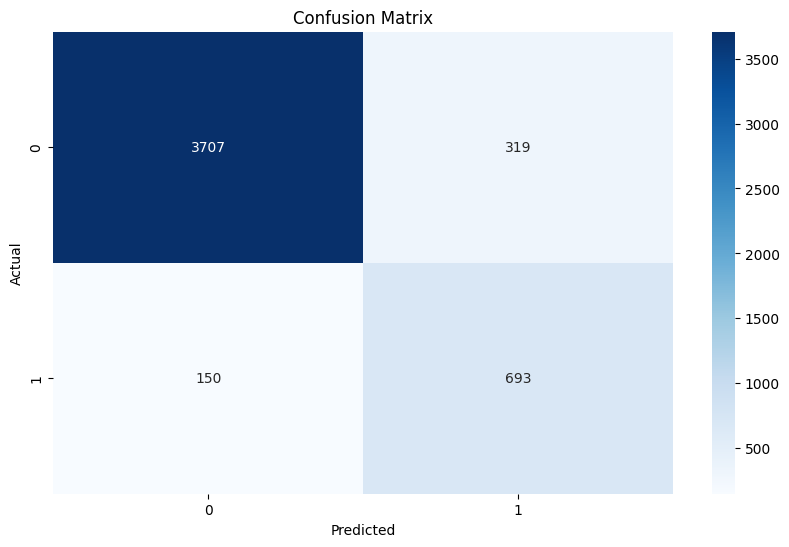

In [78]:
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

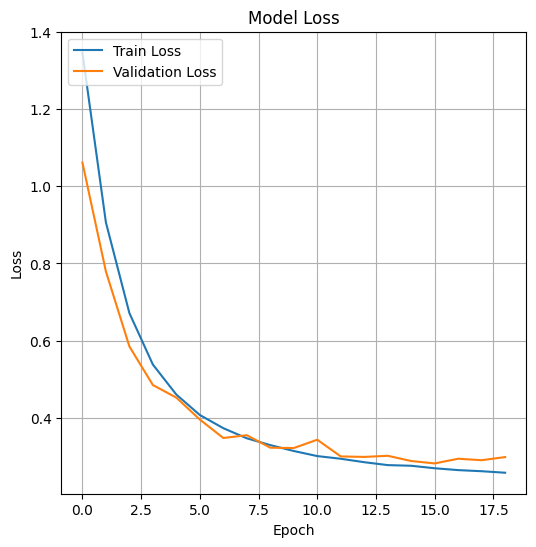

In [79]:
# Plot training & validation loss values
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [80]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4026
         1.0       0.68      0.82      0.75       843

    accuracy                           0.90      4869
   macro avg       0.82      0.87      0.84      4869
weighted avg       0.91      0.90      0.91      4869

